In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def load_and_explore_data(file_path):
    """Load the dataset and perform comprehensive EDA"""
    
    # Load the data
    print("="*60)
    print("INTENT DETECTION - EXPLORATORY DATA ANALYSIS")
    print("="*60)
    
    df = pd.read_csv(file_path)
    
    # Basic dataset information
    print(f"\n📊 DATASET OVERVIEW")
    print("-" * 30)
    print(f"Total samples: {len(df)}")
    print(f"Number of features: {len(df.columns)}")
    print(f"Features: {list(df.columns)}")
    print(f"Unique intents: {df['label'].nunique()}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    
    return df

def analyze_class_distribution(df):
    """Analyze and visualize class distribution"""
    
    print(f"\n📈 CLASS DISTRIBUTION ANALYSIS")
    print("-" * 35)
    
    # Get class counts
    class_counts = df['label'].value_counts().sort_values(ascending=False)
    class_percentages = (class_counts / len(df) * 100).round(2)
    
    # Display class distribution table
    print("\nClass Distribution:")
    print("-" * 50)
    for intent, count in class_counts.items():
        percentage = class_percentages[intent]
        print(f"{intent:<25} {count:>3} samples ({percentage:>5.1f}%)")
    
    # Statistics
    print(f"\nDistribution Statistics:")
    print(f"Most frequent class: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")
    print(f"Least frequent class: {class_counts.index[-1]} ({class_counts.iloc[-1]} samples)")
    print(f"Average samples per class: {class_counts.mean():.1f}")
    print(f"Standard deviation: {class_counts.std():.1f}")
    print(f"Class imbalance ratio: {class_counts.iloc[0] / class_counts.iloc[-1]:.1f}:1")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Class Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Horizontal bar plot
    ax1 = axes[0, 0]
    class_counts.plot(kind='barh', ax=ax1, color='skyblue', edgecolor='navy', alpha=0.7)
    ax1.set_title('Samples per Intent Class', fontweight='bold')
    ax1.set_xlabel('Number of Samples')
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Pie chart (top 10 classes to avoid clutter)
    ax2 = axes[0, 1]
    top_10_classes = class_counts.head(10)
    others_count = class_counts.tail(-10).sum()
    if others_count > 0:
        pie_data = list(top_10_classes.values) + [others_count]
        pie_labels = list(top_10_classes.index) + ['Others']
    else:
        pie_data = top_10_classes.values
        pie_labels = top_10_classes.index
    
    ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Class Distribution (Pie Chart)', fontweight='bold')
    
    # 3. Distribution histogram
    ax3 = axes[1, 0]
    ax3.hist(class_counts.values, bins=10, color='lightcoral', alpha=0.7, edgecolor='black')
    ax3.set_title('Distribution of Sample Counts', fontweight='bold')
    ax3.set_xlabel('Number of Samples per Class')
    ax3.set_ylabel('Number of Classes')
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Cumulative percentage
    ax4 = axes[1, 1]
    cumulative_pct = class_percentages.cumsum()
    ax4.plot(range(1, len(cumulative_pct) + 1), cumulative_pct.values, 
             marker='o', linewidth=2, markersize=4, color='green')
    ax4.set_title('Cumulative Class Distribution', fontweight='bold')
    ax4.set_xlabel('Number of Classes (Ranked)')
    ax4.set_ylabel('Cumulative Percentage (%)')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% line')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return class_counts

def show_random_samples(df, samples_per_class=3):
    """Display random samples for each class"""
    
    print(f"\n🎲 RANDOM SAMPLES FROM EACH CLASS")
    print("-" * 40)
    
    classes = df['label'].unique()
    
    for intent in sorted(classes):
        class_data = df[df['label'] == intent]
        n_samples = min(samples_per_class, len(class_data))
        random_samples = class_data.sample(n=n_samples, random_state=42)
        
        print(f"\n🏷️  {intent} ({len(class_data)} total samples)")
        print("-" * (len(intent) + 25))
        
        for idx, (_, row) in enumerate(random_samples.iterrows(), 1):
            sentence = row['sentence'].strip()
            print(f"  {idx}. \"{sentence}\"")

def analyze_text_characteristics(df):
    """Analyze text characteristics"""
    
    print(f"\n📝 TEXT CHARACTERISTICS ANALYSIS")
    print("-" * 38)
    
    # Calculate text statistics
    df['sentence_length'] = df['sentence'].str.len()
    df['word_count'] = df['sentence'].str.split().str.len()
    df['char_count'] = df['sentence'].str.len()
    
    # Overall statistics
    print("Overall Text Statistics:")
    print(f"Average sentence length: {df['sentence_length'].mean():.1f} characters")
    print(f"Average word count: {df['word_count'].mean():.1f} words")
    print(f"Shortest sentence: {df['sentence_length'].min()} characters")
    print(f"Longest sentence: {df['sentence_length'].max()} characters")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Text Characteristics Analysis', fontsize=16, fontweight='bold')
    
    # 1. Sentence length distribution
    ax1 = axes[0, 0]
    ax1.hist(df['sentence_length'], bins=20, color='lightblue', alpha=0.7, edgecolor='black')
    ax1.set_title('Distribution of Sentence Lengths')
    ax1.set_xlabel('Number of Characters')
    ax1.set_ylabel('Frequency')
    ax1.axvline(df['sentence_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["sentence_length"].mean():.1f}')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Word count distribution
    ax2 = axes[0, 1]
    ax2.hist(df['word_count'], bins=15, color='lightgreen', alpha=0.7, edgecolor='black')
    ax2.set_title('Distribution of Word Counts')
    ax2.set_xlabel('Number of Words')
    ax2.set_ylabel('Frequency')
    ax2.axvline(df['word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["word_count"].mean():.1f}')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Box plot of sentence lengths by class (top 10 classes)
    ax3 = axes[1, 0]
    top_classes = df['label'].value_counts().head(10).index
    df_top = df[df['label'].isin(top_classes)]
    
    sns.boxplot(data=df_top, y='label', x='sentence_length', ax=ax3, palette='Set2')
    ax3.set_title('Sentence Length by Intent (Top 10 Classes)')
    ax3.set_xlabel('Sentence Length (characters)')
    ax3.set_ylabel('Intent')
    
    # 4. Scatter plot: word count vs sentence length
    ax4 = axes[1, 1]
    scatter = ax4.scatter(df['word_count'], df['sentence_length'], 
                         c=pd.factorize(df['label'])[0], alpha=0.6, s=30)
    ax4.set_title('Word Count vs Sentence Length')
    ax4.set_xlabel('Word Count')
    ax4.set_ylabel('Sentence Length (characters)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_vocabulary(df):
    """Analyze vocabulary and common words"""
    
    print(f"\n📚 VOCABULARY ANALYSIS")
    print("-" * 28)
    
    # Tokenize all sentences
    all_text = ' '.join(df['sentence'].str.lower())
    words = re.findall(r'\b\w+\b', all_text)
    
    # Overall vocabulary statistics
    vocab_size = len(set(words))
    total_words = len(words)
    
    print(f"Total vocabulary size: {vocab_size} unique words")
    print(f"Total word occurrences: {total_words}")
    print(f"Average words per sentence: {total_words/len(df):.1f}")
    
    # Most common words
    word_freq = Counter(words)
    print(f"\nTop 15 Most Common Words:")
    print("-" * 30)
    for word, count in word_freq.most_common(15):
        print(f"{word:<15} {count:>3} occurrences")
    
    # Create word cloud and frequency plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Vocabulary Analysis', fontsize=16, fontweight='bold')
    
    # 1. Word cloud
    ax1 = axes[0, 0]
    wordcloud = WordCloud(width=400, height=300, background_color='white',
                         max_words=50, colormap='viridis').generate(all_text)
    ax1.imshow(wordcloud, interpolation='bilinear')
    ax1.set_title('Word Cloud (Top 50 Words)')
    ax1.axis('off')
    
    # 2. Top words frequency
    ax2 = axes[0, 1]
    top_words = dict(word_freq.most_common(15))
    ax2.barh(list(top_words.keys()), list(top_words.values()), color='coral', alpha=0.7)
    ax2.set_title('Top 15 Most Frequent Words')
    ax2.set_xlabel('Frequency')
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Word frequency distribution
    ax3 = axes[1, 0]
    frequencies = list(word_freq.values())
    ax3.hist(frequencies, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
    ax3.set_title('Word Frequency Distribution')
    ax3.set_xlabel('Word Frequency')
    ax3.set_ylabel('Number of Words')
    ax3.set_yscale('log')
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Vocabulary richness by class
    ax4 = axes[1, 1]
    class_vocab_size = []
    class_names = []
    
    for intent in df['label'].unique():
        class_text = ' '.join(df[df['label'] == intent]['sentence'].str.lower())
        class_words = set(re.findall(r'\b\w+\b', class_text))
        class_vocab_size.append(len(class_words))
        class_names.append(intent)
    
    # Sort by vocabulary size
    vocab_data = list(zip(class_names, class_vocab_size))
    vocab_data.sort(key=lambda x: x[1], reverse=True)
    names, sizes = zip(*vocab_data)
    
    ax4.barh(names[:15], sizes[:15], color='lightgreen', alpha=0.7)
    ax4.set_title('Vocabulary Size by Intent (Top 15)')
    ax4.set_xlabel('Unique Words')
    ax4.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def intent_specific_analysis(df):
    """Analyze specific patterns for each intent"""
    
    print(f"\n🎯 INTENT-SPECIFIC ANALYSIS")
    print("-" * 32)
    
    # Key statistics per intent
    intent_stats = []
    
    for intent in df['label'].unique():
        intent_data = df[df['label'] == intent]
        
        # Calculate statistics
        avg_length = intent_data['sentence'].str.len().mean()
        avg_words = intent_data['sentence'].str.split().str.len().mean()
        unique_words = len(set(' '.join(intent_data['sentence'].str.lower()).split()))
        
        intent_stats.append({
            'Intent': intent,
            'Samples': len(intent_data),
            'Avg_Length': round(avg_length, 1),
            'Avg_Words': round(avg_words, 1),
            'Unique_Words': unique_words
        })
    
    # Create DataFrame and display
    stats_df = pd.DataFrame(intent_stats).sort_values('Samples', ascending=False)
    
    print("Intent-wise Statistics:")
    print("-" * 70)
    print(f"{'Intent':<25} {'Samples':<8} {'Avg_Len':<8} {'Avg_Words':<10} {'Vocab':<8}")
    print("-" * 70)
    
    for _, row in stats_df.iterrows():
        print(f"{row['Intent']:<25} {row['Samples']:<8} {row['Avg_Length']:<8} "
              f"{row['Avg_Words']:<10} {row['Unique_Words']:<8}")

def generate_summary_insights(df, class_counts):
    """Generate key insights and recommendations"""
    
    print(f"\n💡 KEY INSIGHTS & RECOMMENDATIONS")
    print("-" * 40)
    
    # Calculate key metrics
    total_samples = len(df)
    num_classes = len(class_counts)
    imbalance_ratio = class_counts.iloc[0] / class_counts.iloc[-1]
    avg_samples_per_class = total_samples / num_classes
    
    print("📋 DATASET INSIGHTS:")
    print("-" * 20)
    print(f"• Dataset is {'SMALL' if total_samples < 1000 else 'LARGE'} with {total_samples} samples")
    print(f"• High class imbalance (ratio: {imbalance_ratio:.1f}:1)")
    print(f"• Some classes have very few samples (minimum: {class_counts.iloc[-1]})")
    print(f"• Average sentence length: {df['sentence'].str.len().mean():.1f} characters")
    print(f"• Vocabulary appears domain-specific (mattress, EMI, COD terms)")
    
    print(f"\n🎯 MODELING RECOMMENDATIONS:")
    print("-" * 28)
    print("• Address class imbalance using:")
    print("  - Class weighting in loss function")
    print("  - SMOTE or other oversampling techniques")
    print("  - Stratified train-test split")
    print("• Consider data augmentation:")
    print("  - Synonym replacement")
    print("  - Paraphrasing for minority classes")
    print("• Use appropriate evaluation metrics:")
    print("  - Macro F1-score (handles imbalance)")
    print("  - Per-class precision/recall")
    print("  - Confusion matrix analysis")
    print("• Start with simpler models:")
    print("  - TF-IDF + Logistic Regression")
    print("  - Then progress to transformer models")

def run_complete_eda(file_path='/Users/santhosh/Documents/Tifin_Test_1/data/sofmattress_train.csv'):
    """Run complete EDA pipeline"""
    
    try:
        # Load data
        df = load_and_explore_data(file_path)
        
        # Run all analyses
        class_counts = analyze_class_distribution(df)
        show_random_samples(df, samples_per_class=3)
        analyze_text_characteristics(df)
        analyze_vocabulary(df)
        intent_specific_analysis(df)
        generate_summary_insights(df, class_counts)
        
        print(f"\n✅ EDA COMPLETED SUCCESSFULLY!")
        print("="*60)
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Error: File '{file_path}' not found!")
        print("Please make sure the CSV file is in the same directory.")
        return None
    except Exception as e:
        print(f"❌ Error during EDA: {str(e)}")
        return None


INTENT DETECTION - EXPLORATORY DATA ANALYSIS

📊 DATASET OVERVIEW
------------------------------
Total samples: 328
Number of features: 2
Features: ['sentence', 'label']
Unique intents: 21
Missing values: 0

📈 CLASS DISTRIBUTION ANALYSIS
-----------------------------------

Class Distribution:
--------------------------------------------------
DISTRIBUTORS               34 samples ( 10.4%)
EMI                        25 samples (  7.6%)
MATTRESS_COST              22 samples (  6.7%)
LEAD_GEN                   21 samples (  6.4%)
PRODUCT_VARIANTS           21 samples (  6.4%)
ORDER_STATUS               21 samples (  6.4%)
WHAT_SIZE_TO_ORDER         20 samples (  6.1%)
100_NIGHT_TRIAL_OFFER      18 samples (  5.5%)
ORTHO_FEATURES             17 samples (  5.2%)
RETURN_EXCHANGE            14 samples (  4.3%)
COD                        12 samples (  3.7%)
COMPARISON                 11 samples (  3.4%)
ERGO_FEATURES              11 samples (  3.4%)
ABOUT_SOF_MATTRESS         11 samples (  3.4

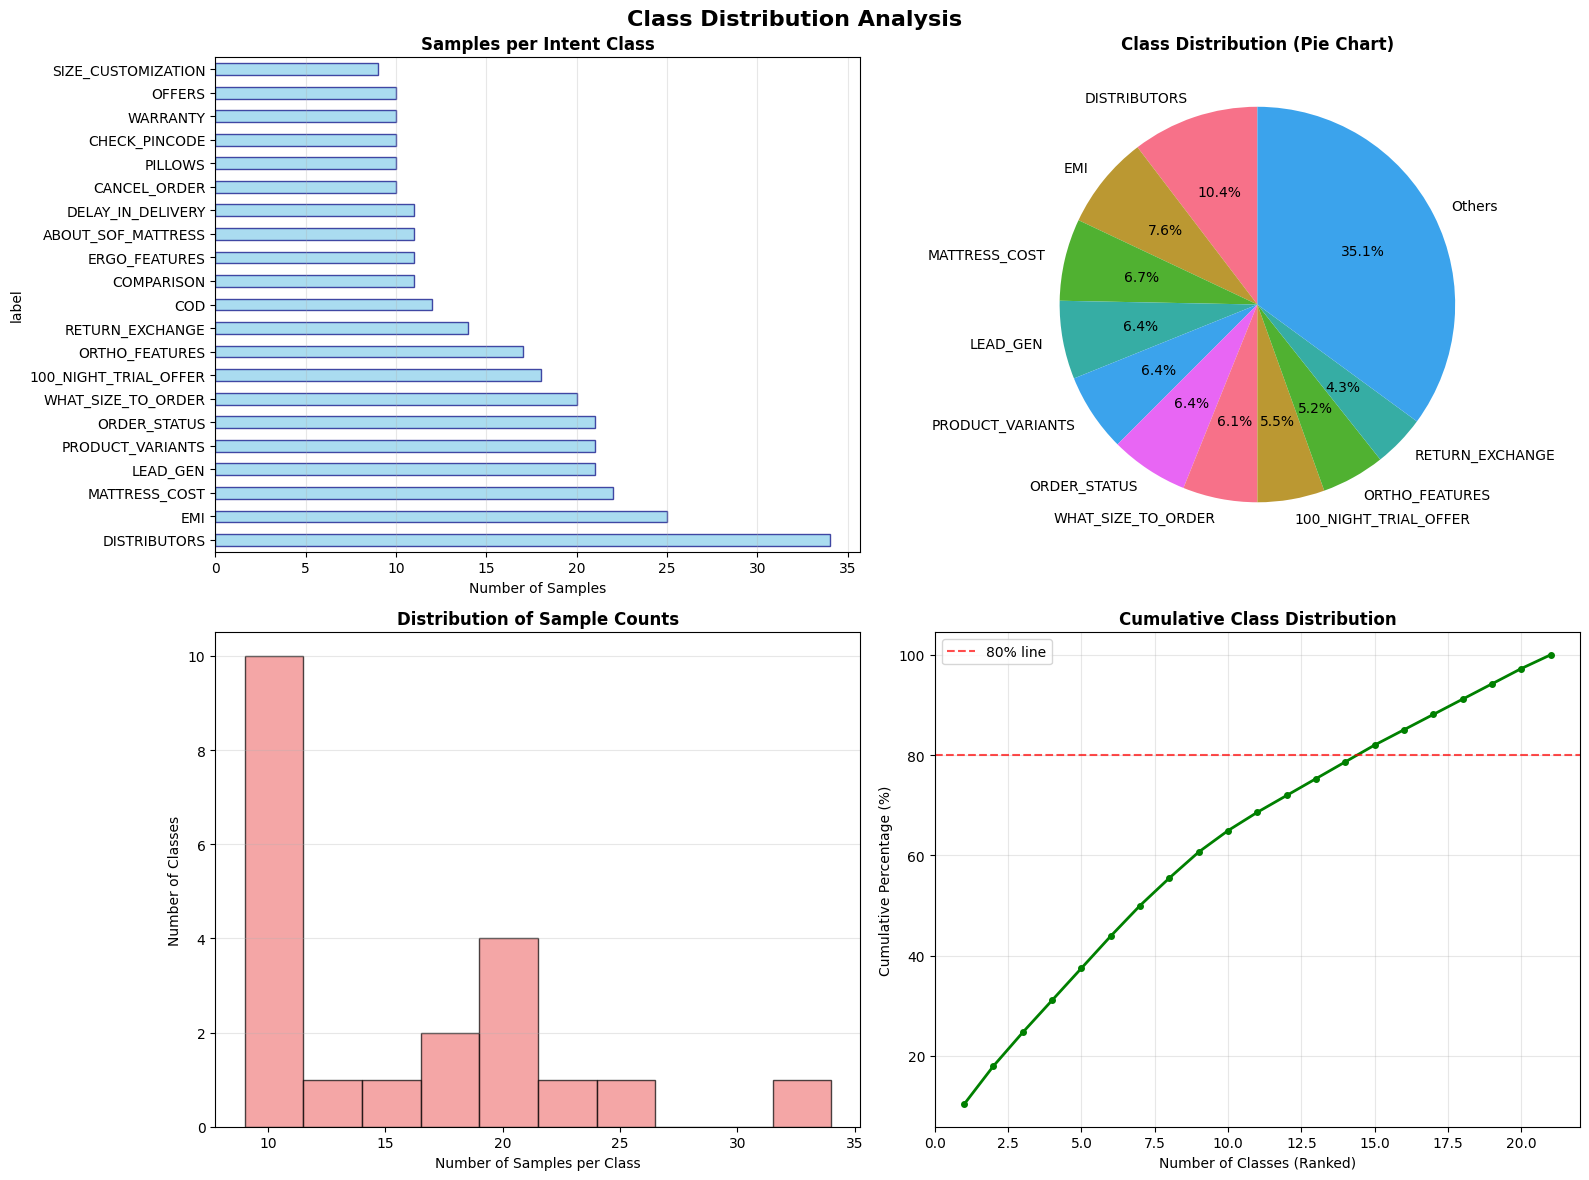


🎲 RANDOM SAMPLES FROM EACH CLASS
----------------------------------------

🏷️  100_NIGHT_TRIAL_OFFER (18 total samples)
----------------------------------------------
  1. "How does the 100 night trial work"
  2. "What is the 100-night offer"
  3. "do you provide exchange"

🏷️  ABOUT_SOF_MATTRESS (11 total samples)
-------------------------------------------
  1. "Who are SOF mattress"
  2. "How is SOF different from other mattress brands"
  3. "Tell me about company"

🏷️  CANCEL_ORDER (10 total samples)
-------------------------------------
  1. "Process of cancelling order"
  2. "How can I cancel my order"
  3. "Cancel the order"

🏷️  CHECK_PINCODE (10 total samples)
--------------------------------------
  1. "Need a delivery on this pincode"
  2. "Check pincode"
  3. "Can you deliver on my pincode"

🏷️  COD (12 total samples)
----------------------------
  1. "Can I get COD option?"
  2. "Is COD option available"
  3. "COD option is availble?"

🏷️  COMPARISON (11 total samples)
--

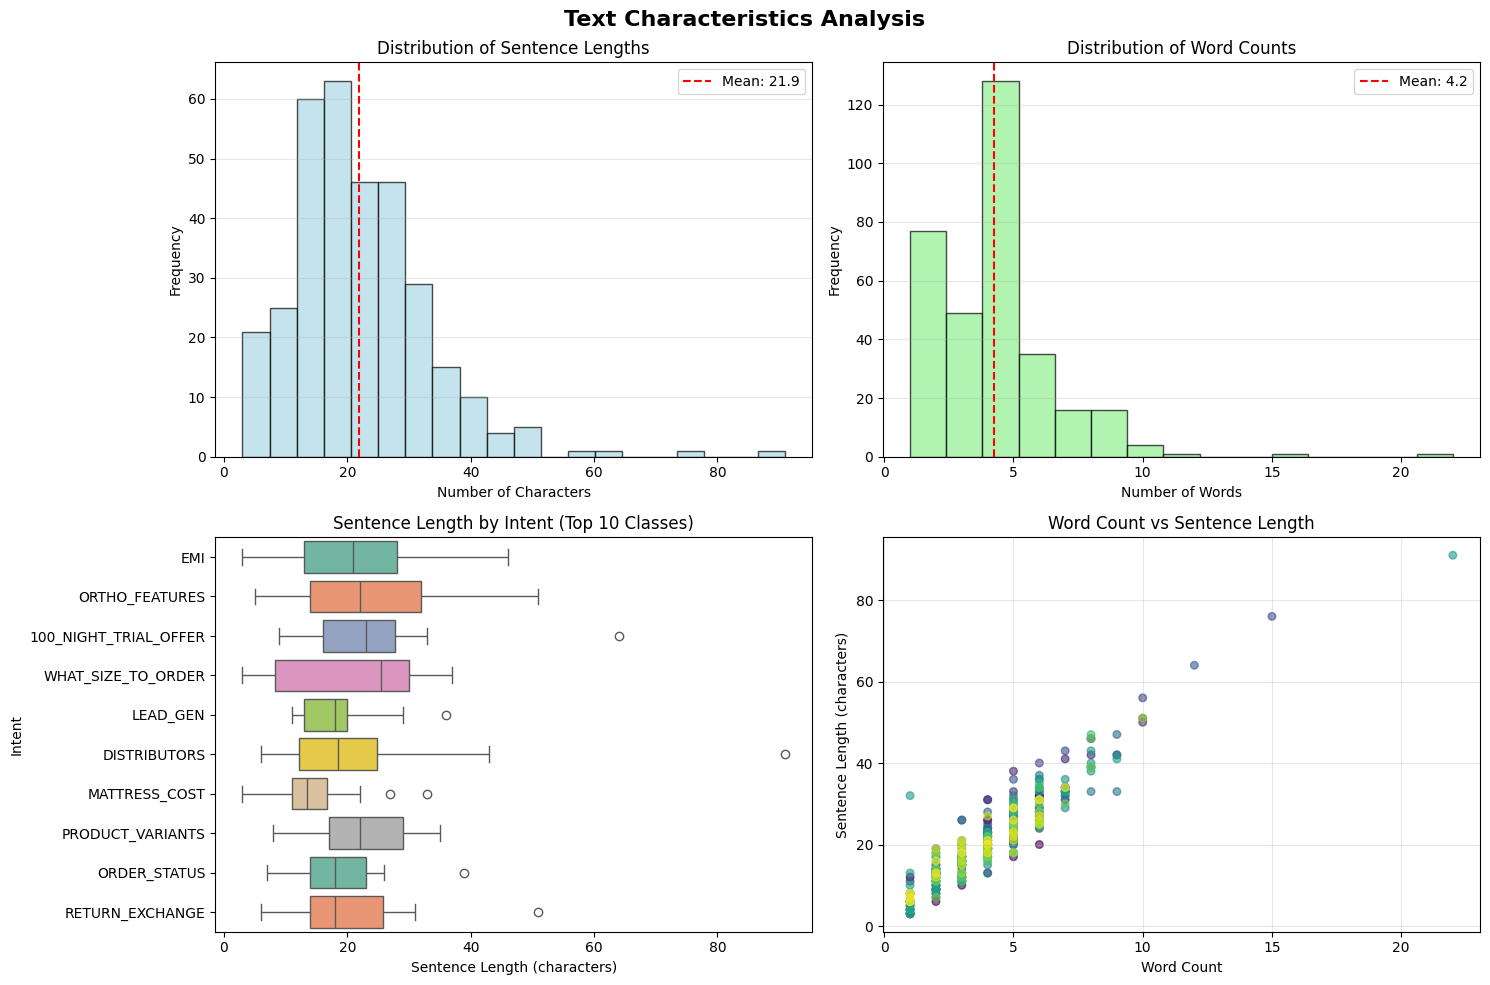


📚 VOCABULARY ANALYSIS
----------------------------
Total vocabulary size: 286 unique words
Total word occurrences: 1399
Average words per sentence: 4.3

Top 15 Most Common Words:
------------------------------
mattress         54 occurrences
the              54 occurrences
i                51 occurrences
is               45 occurrences
to               41 occurrences
what             34 occurrences
order            32 occurrences
my               27 occurrences
you              26 occurrences
can              26 occurrences
want             25 occurrences
do               23 occurrences
of               21 occurrences
sof              21 occurrences
me               21 occurrences


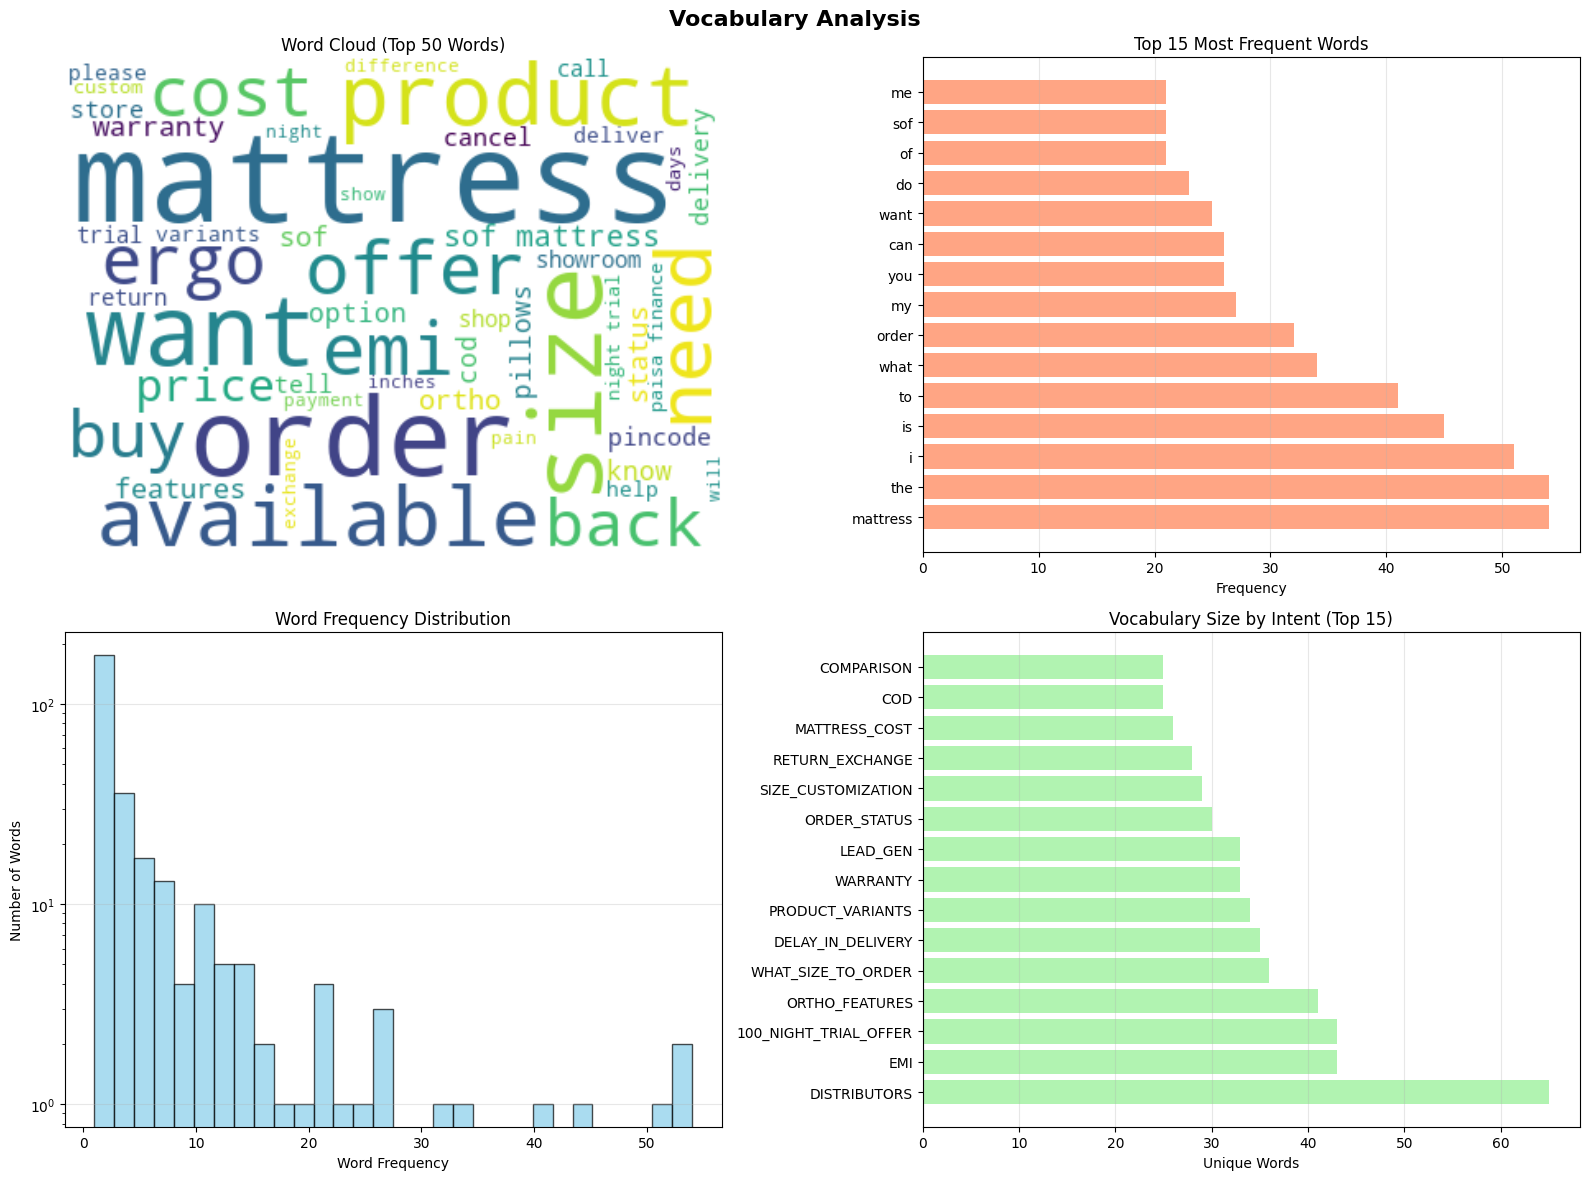


🎯 INTENT-SPECIFIC ANALYSIS
--------------------------------
Intent-wise Statistics:
----------------------------------------------------------------------
Intent                    Samples  Avg_Len  Avg_Words  Vocab   
----------------------------------------------------------------------
DISTRIBUTORS              34       22.1     4.3        69      
EMI                       25       20.6     4.0        48      
MATTRESS_COST             22       14.3     2.9        26      
LEAD_GEN                  21       18.2     4.1        35      
PRODUCT_VARIANTS          21       22.2     3.9        34      
ORDER_STATUS              21       18.7     3.9        32      
WHAT_SIZE_TO_ORDER        20       20.9     4.2        39      
100_NIGHT_TRIAL_OFFER     18       24.3     4.8        44      
ORTHO_FEATURES            17       24.1     4.4        41      
RETURN_EXCHANGE           14       20.0     3.9        29      
COD                       12       22.0     4.6        27      
COMPA

In [5]:

df = run_complete_eda('/Users/santhosh/Documents/Tifin_Test_1/data/sofmattress_train.csv')

In [6]:
9/34

0.2647058823529412

In [7]:
34/9


3.7777777777777777

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Define custom stop words (excluding important words like "not")
STOP_WORDS = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
              'of', 'with', 'by', 'from', 'up', 'about', 'above', 'after', 'again', 
              'against', 'all', 'am', 'are', 'as', 'at', 'be', 'been', 'being', 
              'below', 'between', 'both', 'but', 'by', 'could', 'did', 'do', 'does', 
              'doing', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 
              'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 
              'him', 'himself', 'his', 'how', 'if', 'in', 'into', 'is', 'it', 'its', 
              'itself', 'me', 'more', 'most', 'my', 'myself', 'of', 'off', 'on', 
              'once', 'only', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 
              'own', 'same', 'she', 'should', 'so', 'some', 'such', 'than', 'that', 
              'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 
              'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 
              'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 
              'who', 'whom', 'why', 'will', 'with', 'would', 'you', 'your', 'yours', 
              'yourself', 'yourselves','want','need','can','cannot','should','shouldn','shouldn','s'}

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def load_and_explore_data(file_path):
    """Load the dataset and perform comprehensive EDA"""
    
    # Load the data
    print("="*60)
    print("INTENT DETECTION - EXPLORATORY DATA ANALYSIS")
    print("="*60)
    
    df = pd.read_csv(file_path)
    
    # Basic dataset information
    print(f"\n📊 DATASET OVERVIEW")
    print("-" * 30)
    print(f"Total samples: {len(df)}")
    print(f"Number of features: {len(df.columns)}")
    print(f"Features: {list(df.columns)}")
    print(f"Unique intents: {df['label'].nunique()}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    
    return df

def analyze_class_distribution(df):
    """Analyze and visualize class distribution"""
    
    print(f"\n📈 CLASS DISTRIBUTION ANALYSIS")
    print("-" * 35)
    
    # Get class counts
    class_counts = df['label'].value_counts().sort_values(ascending=False)
    class_percentages = (class_counts / len(df) * 100).round(2)
    
    # Display class distribution table
    print("\nClass Distribution:")
    print("-" * 50)
    for intent, count in class_counts.items():
        percentage = class_percentages[intent]
        print(f"{intent:<25} {count:>3} samples ({percentage:>5.1f}%)")
    
    # Statistics
    print(f"\nDistribution Statistics:")
    print(f"Most frequent class: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")
    print(f"Least frequent class: {class_counts.index[-1]} ({class_counts.iloc[-1]} samples)")
    print(f"Average samples per class: {class_counts.mean():.1f}")
    print(f"Standard deviation: {class_counts.std():.1f}")
    print(f"Class imbalance ratio: {class_counts.iloc[0] / class_counts.iloc[-1]:.1f}:1")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Class Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Horizontal bar plot
    ax1 = axes[0, 0]
    class_counts.plot(kind='barh', ax=ax1, color='skyblue', edgecolor='navy', alpha=0.7)
    ax1.set_title('Samples per Intent Class', fontweight='bold')
    ax1.set_xlabel('Number of Samples')
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Pie chart (all classes)
    ax2 = axes[0, 1]
    ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
            startangle=90, textprops={'fontsize': 8})
    ax2.set_title('Class Distribution (Pie Chart)', fontweight='bold')
    
    # 3. Distribution histogram with class labels
    ax3 = axes[1, 0]
    bars = ax3.hist(class_counts.values, bins=min(10, len(class_counts)), 
                    color='lightcoral', alpha=0.7, edgecolor='black')
    ax3.set_title('Distribution of Sample Counts', fontweight='bold')
    ax3.set_xlabel('Number of Samples per Class')
    ax3.set_ylabel('Number of Classes')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add class labels to histogram
    for i, (intent, count) in enumerate(class_counts.items()):
        # Find which bin this count belongs to
        bin_edges = bars[1]
        for j in range(len(bin_edges)-1):
            if bin_edges[j] <= count < bin_edges[j+1]:
                ax3.text(count, 0.1, intent, rotation=90, fontsize=8, 
                        ha='center', va='bottom', alpha=0.8)
                break
    
    # 4. Average samples per class (instead of cumulative)
    ax4 = axes[1, 1]
    ax4.axhline(y=class_counts.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Average: {class_counts.mean():.1f}')
    ax4.bar(range(len(class_counts)), class_counts.values, 
            color='green', alpha=0.6, edgecolor='darkgreen')
    ax4.set_title('Samples per Class (Sorted)', fontweight='bold')
    ax4.set_xlabel('Class Rank')
    ax4.set_ylabel('Number of Samples')
    ax4.grid(axis='y', alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return class_counts

def show_random_samples(df, samples_per_class=3):
    """Display random samples for each class"""
    
    print(f"\n🎲 RANDOM SAMPLES FROM EACH CLASS")
    print("-" * 40)
    
    classes = df['label'].unique()
    
    for intent in sorted(classes):
        class_data = df[df['label'] == intent]
        n_samples = min(samples_per_class, len(class_data))
        random_samples = class_data.sample(n=n_samples, random_state=42)
        
        print(f"\n🏷️  {intent} ({len(class_data)} total samples)")
        print("-" * (len(intent) + 25))
        
        for idx, (_, row) in enumerate(random_samples.iterrows(), 1):
            sentence = row['sentence'].strip()
            print(f"  {idx}. \"{sentence}\"")

def analyze_text_characteristics(df):
    """Analyze text characteristics"""
    
    print(f"\n📝 TEXT CHARACTERISTICS ANALYSIS")
    print("-" * 38)
    
    # Calculate text statistics
    df['sentence_length'] = df['sentence'].str.len()
    df['word_count'] = df['sentence'].str.split().str.len()
    df['char_count'] = df['sentence'].str.len()
    
    # Overall statistics
    print("Overall Text Statistics:")
    print(f"Average sentence length: {df['sentence_length'].mean():.1f} characters")
    print(f"Average word count: {df['word_count'].mean():.1f} words")
    print(f"Shortest sentence: {df['sentence_length'].min()} characters")
    print(f"Longest sentence: {df['sentence_length'].max()} characters")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Text Characteristics Analysis', fontsize=16, fontweight='bold')
    
    # 1. Sentence length distribution
    ax1 = axes[0, 0]
    ax1.hist(df['sentence_length'], bins=20, color='lightblue', alpha=0.7, edgecolor='black')
    ax1.set_title('Distribution of Sentence Lengths')
    ax1.set_xlabel('Number of Characters')
    ax1.set_ylabel('Frequency')
    ax1.axvline(df['sentence_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["sentence_length"].mean():.1f}')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Word count distribution
    ax2 = axes[0, 1]
    ax2.hist(df['word_count'], bins=15, color='lightgreen', alpha=0.7, edgecolor='black')
    ax2.set_title('Distribution of Word Counts')
    ax2.set_xlabel('Number of Words')
    ax2.set_ylabel('Frequency')
    ax2.axvline(df['word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["word_count"].mean():.1f}')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Box plot of sentence lengths by class (top 10 classes)
    ax3 = axes[1, 0]
    top_classes = df['label'].value_counts().head(10).index
    df_top = df[df['label'].isin(top_classes)]
    
    sns.boxplot(data=df_top, y='label', x='sentence_length', ax=ax3, palette='Set2')
    ax3.set_title('Sentence Length by Intent (Top 10 Classes)')
    ax3.set_xlabel('Sentence Length (characters)')
    ax3.set_ylabel('Intent')
    
    # 4. Scatter plot: word count vs sentence length
    ax4 = axes[1, 1]
    scatter = ax4.scatter(df['word_count'], df['sentence_length'], 
                         c=pd.factorize(df['label'])[0], alpha=0.6, s=30)
    ax4.set_title('Word Count vs Sentence Length')
    ax4.set_xlabel('Word Count')
    ax4.set_ylabel('Sentence Length (characters)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_vocabulary(df):
    """Analyze vocabulary and common words"""
    
    print(f"\n📚 VOCABULARY ANALYSIS")
    print("-" * 28)
    
    # Function to clean text and remove stop words (but keep "not")
    def clean_text(text):
        words = re.findall(r'\b\w+\b', text.lower())
        return [word for word in words if word not in STOP_WORDS or word == 'not']
    
    # Tokenize all sentences (removing stop words)
    all_words = []
    for sentence in df['sentence']:
        all_words.extend(clean_text(sentence))
    
    # Overall vocabulary statistics
    vocab_size = len(set(all_words))
    total_words = len(all_words)
    
    print(f"Total vocabulary size: {vocab_size} unique words (after removing stop words)")
    print(f"Total word occurrences: {total_words}")
    print(f"Average words per sentence: {total_words/len(df):.1f}")
    
    # Most common words across dataset
    word_freq = Counter(all_words)
    print(f"\n🔟 TOP 10 WORDS ACROSS DATASET:")
    print("-" * 35)
    for i, (word, count) in enumerate(word_freq.most_common(10), 1):
        print(f"{i:2d}. {word:<15} {count:>3} occurrences")
    
    # Top 10 words for each class
    print(f"\n🎯 TOP 10 WORDS FOR EACH CLASS:")
    print("-" * 35)
    
    class_word_freq = {}
    for intent in sorted(df['label'].unique()):
        intent_sentences = df[df['label'] == intent]['sentence']
        intent_words = []
        for sentence in intent_sentences:
            intent_words.extend(clean_text(sentence))
        
        intent_word_freq = Counter(intent_words)
        class_word_freq[intent] = intent_word_freq
        
        print(f"\n{intent}:")
        for i, (word, count) in enumerate(intent_word_freq.most_common(10), 1):
            print(f"  {i:2d}. {word:<12} ({count})")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Vocabulary Analysis', fontsize=16, fontweight='bold')
    
    # 1. Word cloud
    ax1 = axes[0, 0]
    all_text_clean = ' '.join(all_words)
    wordcloud = WordCloud(width=400, height=300, background_color='white',
                         max_words=50, colormap='viridis').generate(all_text_clean)
    ax1.imshow(wordcloud, interpolation='bilinear')
    ax1.set_title('Word Cloud (Top 50 Words, Stop Words Removed)')
    ax1.axis('off')
    
    # 2. Top 10 words frequency
    ax2 = axes[0, 1]
    top_10_words = dict(word_freq.most_common(10))
    bars = ax2.bar(list(top_10_words.keys()), list(top_10_words.values()), 
                   color='coral', alpha=0.7, edgecolor='darkred')
    ax2.set_title('Top 10 Most Frequent Words (Dataset)')
    ax2.set_ylabel('Frequency')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # 3. Top 10 words distribution across classes
    ax3 = axes[1, 0]
    top_10_global = [word for word, _ in word_freq.most_common(10)]
    
    # Create matrix for heatmap
    class_word_matrix = []
    class_labels = sorted(df['label'].unique())
    
    for intent in class_labels:
        intent_counts = []
        for word in top_10_global:
            count = class_word_freq[intent].get(word, 0)
            intent_counts.append(count)
        class_word_matrix.append(intent_counts)
    
    # Create heatmap
    sns.heatmap(class_word_matrix, 
                xticklabels=top_10_global,
                yticklabels=class_labels,
                annot=True, fmt='d', cmap='YlOrRd',
                ax=ax3, cbar_kws={'label': 'Word Count'})
    ax3.set_title('Top 10 Words Distribution Across Classes')
    ax3.set_xlabel('Words')
    ax3.set_ylabel('Intent Classes')
    
    # 4. Class-wise vocabulary richness
    ax4 = axes[1, 1]
    class_vocab_size = []
    class_names = []
    
    for intent in sorted(df['label'].unique()):
        intent_sentences = df[df['label'] == intent]['sentence']
        intent_words = []
        for sentence in intent_sentences:
            intent_words.extend(clean_text(sentence))
        unique_words = len(set(intent_words))
        class_vocab_size.append(unique_words)
        class_names.append(intent)
    
    # Sort by vocabulary size
    vocab_data = list(zip(class_names, class_vocab_size))
    vocab_data.sort(key=lambda x: x[1], reverse=True)
    names, sizes = zip(*vocab_data)
    
    bars = ax4.barh(names, sizes, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    ax4.set_title('Vocabulary Size by Intent (Unique Words)')
    ax4.set_xlabel('Unique Words')
    ax4.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax4.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                f'{int(width)}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return word_freq, class_word_freq

def intent_specific_analysis(df):
    """Analyze specific patterns for each intent"""
    
    print(f"\n🎯 INTENT-SPECIFIC ANALYSIS")
    print("-" * 32)
    
    # Key statistics per intent
    intent_stats = []
    
    for intent in df['label'].unique():
        intent_data = df[df['label'] == intent]
        
        # Calculate statistics
        avg_length = intent_data['sentence'].str.len().mean()
        avg_words = intent_data['sentence'].str.split().str.len().mean()
        unique_words = len(set(' '.join(intent_data['sentence'].str.lower()).split()))
        
        intent_stats.append({
            'Intent': intent,
            'Samples': len(intent_data),
            'Avg_Length': round(avg_length, 1),
            'Avg_Words': round(avg_words, 1),
            'Unique_Words': unique_words
        })
    
    # Create DataFrame and display
    stats_df = pd.DataFrame(intent_stats).sort_values('Samples', ascending=False)
    
    print("Intent-wise Statistics:")
    print("-" * 70)
    print(f"{'Intent':<25} {'Samples':<8} {'Avg_Len':<8} {'Avg_Words':<10} {'Vocab':<8}")
    print("-" * 70)
    
    for _, row in stats_df.iterrows():
        print(f"{row['Intent']:<25} {row['Samples']:<8} {row['Avg_Length']:<8} "
              f"{row['Avg_Words']:<10} {row['Unique_Words']:<8}")

def generate_summary_insights(df, class_counts):
    """Generate key insights and recommendations"""
    
    print(f"\n💡 KEY INSIGHTS & RECOMMENDATIONS")
    print("-" * 40)
    
    # Calculate key metrics
    total_samples = len(df)
    num_classes = len(class_counts)
    imbalance_ratio = class_counts.iloc[0] / class_counts.iloc[-1]
    avg_samples_per_class = total_samples / num_classes
    
    print("📋 DATASET INSIGHTS:")
    print("-" * 20)
    print(f"• Dataset is {'SMALL' if total_samples < 1000 else 'LARGE'} with {total_samples} samples")
    print(f"• High class imbalance (ratio: {imbalance_ratio:.1f}:1)")
    print(f"• Some classes have very few samples (minimum: {class_counts.iloc[-1]})")
    print(f"• Average sentence length: {df['sentence'].str.len().mean():.1f} characters")
    print(f"• Vocabulary appears domain-specific (mattress, EMI, COD terms)")
    
    print(f"\n🎯 MODELING RECOMMENDATIONS:")
    print("-" * 28)
    print("• Address class imbalance using:")
    print("  - Class weighting in loss function")
    print("  - SMOTE or other oversampling techniques")
    print("  - Stratified train-test split")
    print("• Consider data augmentation:")
    print("  - Synonym replacement")
    print("  - Paraphrasing for minority classes")
    print("• Use appropriate evaluation metrics:")
    print("  - Macro F1-score (handles imbalance)")
    print("  - Per-class precision/recall")
    print("  - Confusion matrix analysis")
    print("• Start with simpler models:")
    print("  - TF-IDF + Logistic Regression")
    print("  - Then progress to transformer models")

def run_complete_eda(file_path='sofmattress_train.csv'):
    """Run complete EDA pipeline"""
    
    try:
        # Load data
        df = load_and_explore_data(file_path)
        
        # Run all analyses
        class_counts = analyze_class_distribution(df)
        show_random_samples(df, samples_per_class=3)
        analyze_text_characteristics(df)
        word_freq, class_word_freq = analyze_vocabulary(df)
        intent_specific_analysis(df)
        generate_summary_insights(df, class_counts)
        
        print(f"\n✅ EDA COMPLETED SUCCESSFULLY!")
        print("="*60)
        
        return df, word_freq, class_word_freq
        
    except FileNotFoundError:
        print(f"❌ Error: File '{file_path}' not found!")
        print("Please make sure the CSV file is in the same directory.")
        return None
    except Exception as e:
        print(f"❌ Error during EDA: {str(e)}")
        return None


INTENT DETECTION - EXPLORATORY DATA ANALYSIS

📊 DATASET OVERVIEW
------------------------------
Total samples: 328
Number of features: 2
Features: ['sentence', 'label']
Unique intents: 21
Missing values: 0

📈 CLASS DISTRIBUTION ANALYSIS
-----------------------------------

Class Distribution:
--------------------------------------------------
DISTRIBUTORS               34 samples ( 10.4%)
EMI                        25 samples (  7.6%)
MATTRESS_COST              22 samples (  6.7%)
LEAD_GEN                   21 samples (  6.4%)
PRODUCT_VARIANTS           21 samples (  6.4%)
ORDER_STATUS               21 samples (  6.4%)
WHAT_SIZE_TO_ORDER         20 samples (  6.1%)
100_NIGHT_TRIAL_OFFER      18 samples (  5.5%)
ORTHO_FEATURES             17 samples (  5.2%)
RETURN_EXCHANGE            14 samples (  4.3%)
COD                        12 samples (  3.7%)
COMPARISON                 11 samples (  3.4%)
ERGO_FEATURES              11 samples (  3.4%)
ABOUT_SOF_MATTRESS         11 samples (  3.4

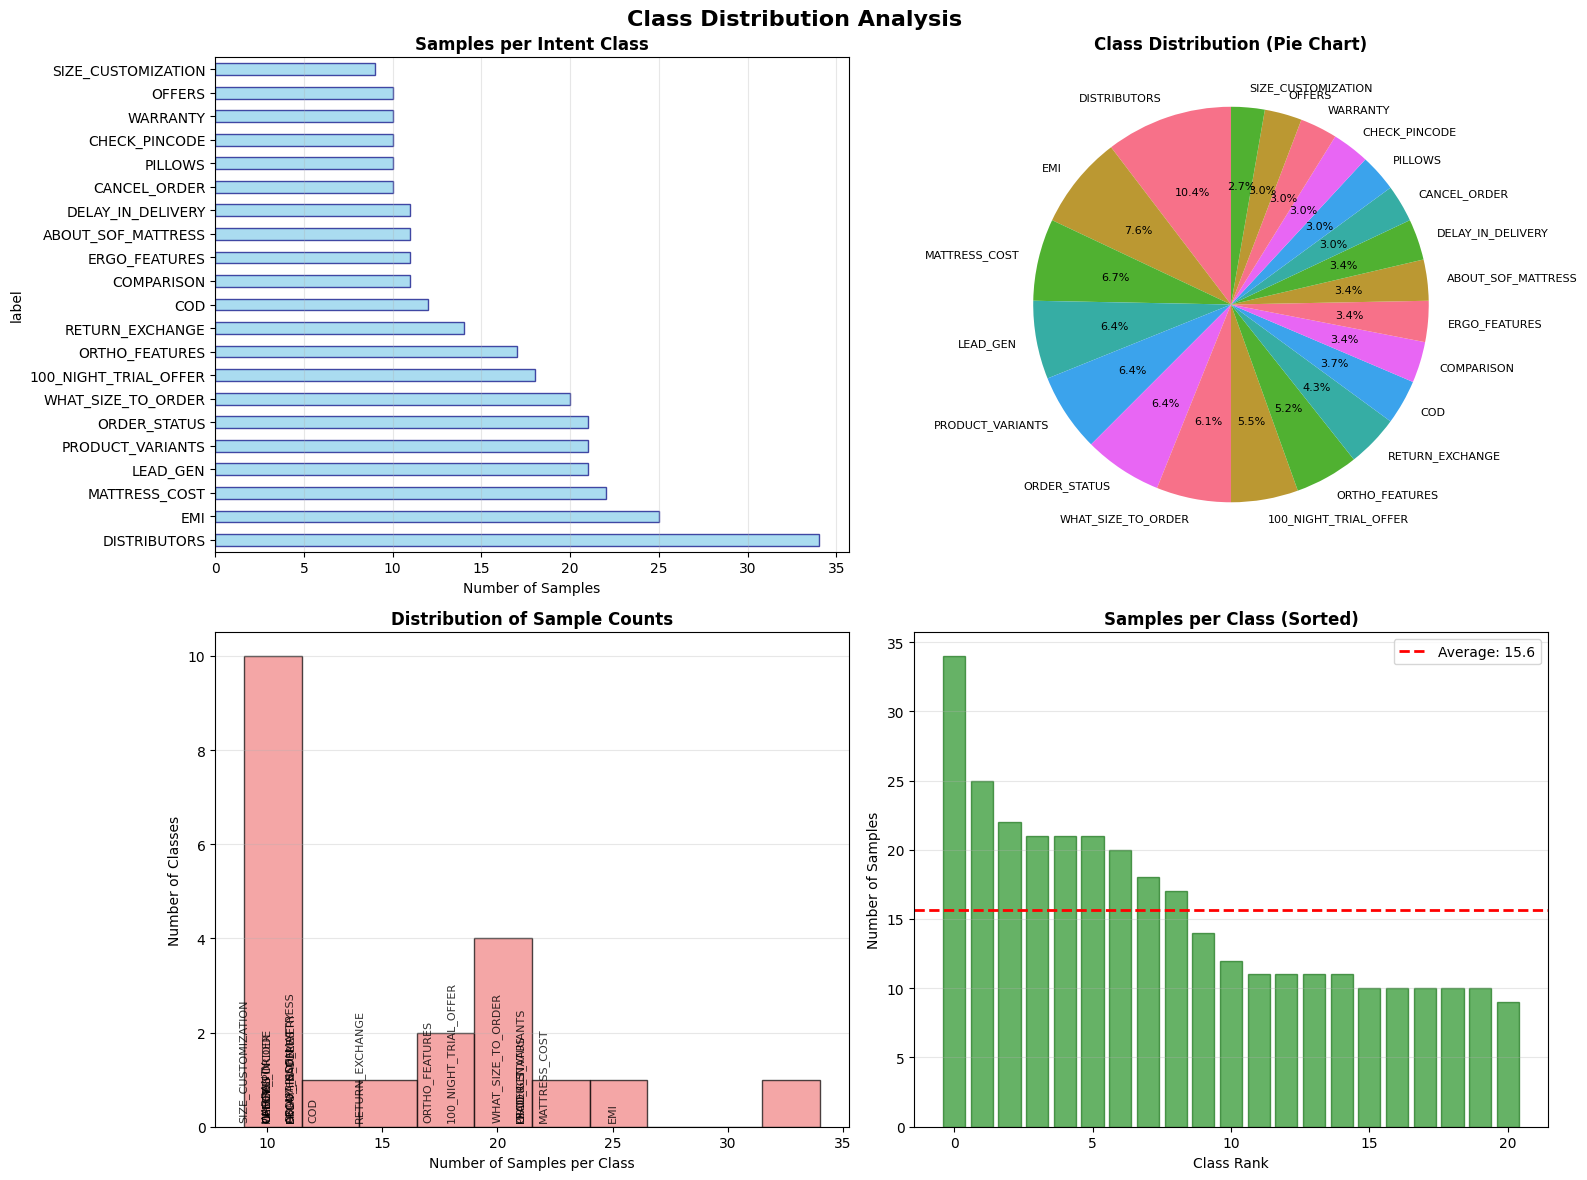


🎲 RANDOM SAMPLES FROM EACH CLASS
----------------------------------------

🏷️  100_NIGHT_TRIAL_OFFER (18 total samples)
----------------------------------------------
  1. "How does the 100 night trial work"
  2. "What is the 100-night offer"
  3. "do you provide exchange"

🏷️  ABOUT_SOF_MATTRESS (11 total samples)
-------------------------------------------
  1. "Who are SOF mattress"
  2. "How is SOF different from other mattress brands"
  3. "Tell me about company"

🏷️  CANCEL_ORDER (10 total samples)
-------------------------------------
  1. "Process of cancelling order"
  2. "How can I cancel my order"
  3. "Cancel the order"

🏷️  CHECK_PINCODE (10 total samples)
--------------------------------------
  1. "Need a delivery on this pincode"
  2. "Check pincode"
  3. "Can you deliver on my pincode"

🏷️  COD (12 total samples)
----------------------------
  1. "Can I get COD option?"
  2. "Is COD option available"
  3. "COD option is availble?"

🏷️  COMPARISON (11 total samples)
--

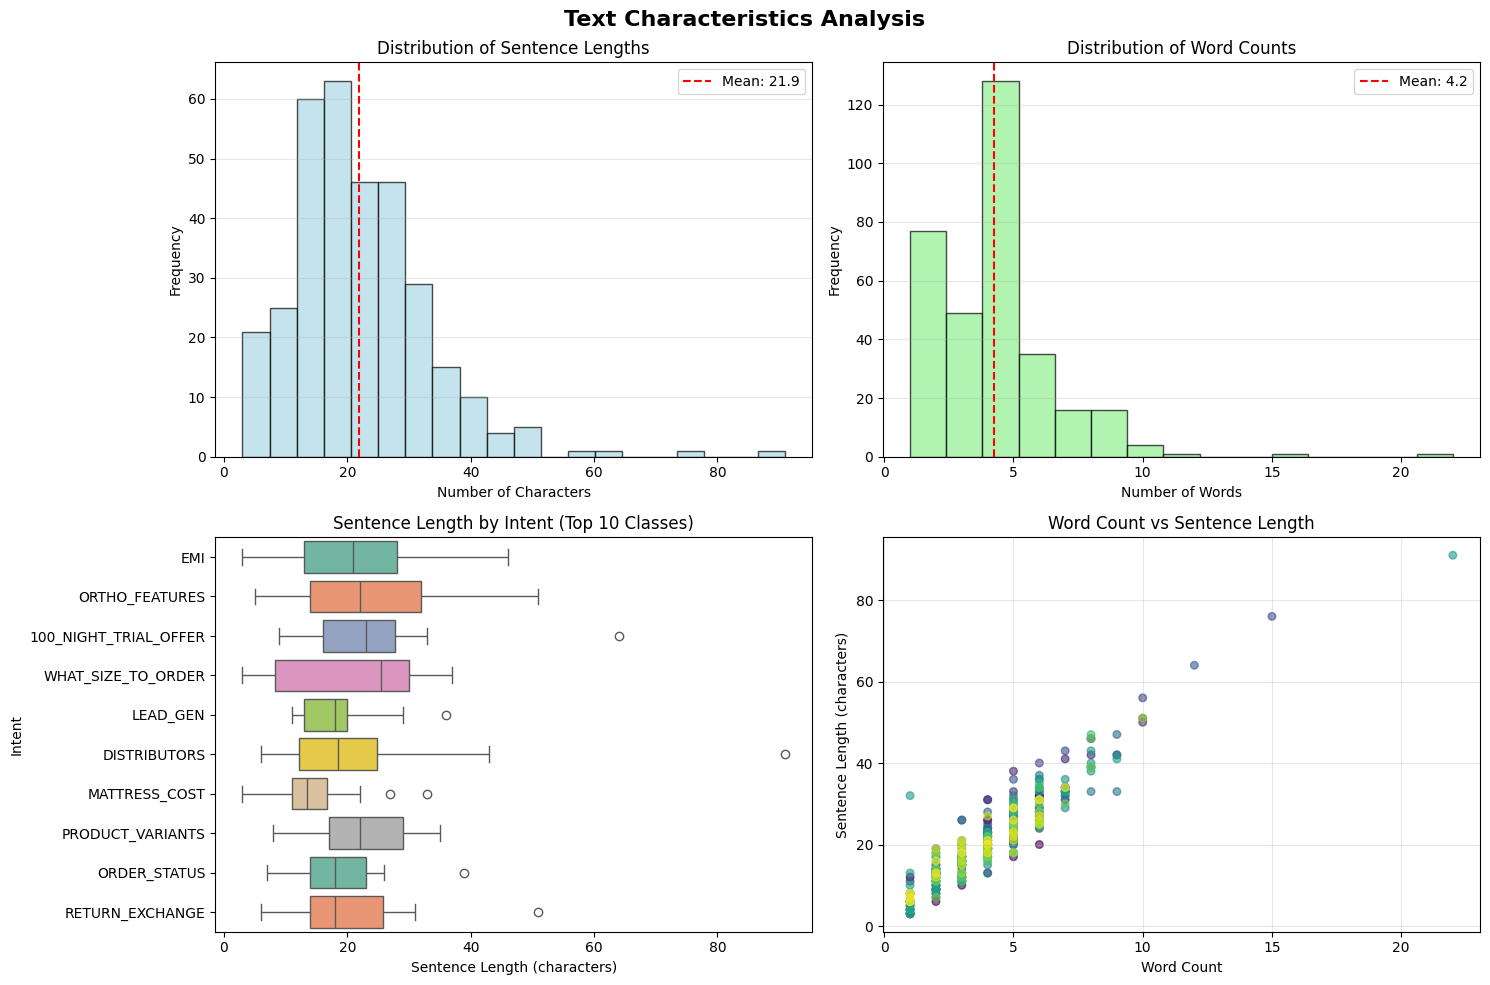


📚 VOCABULARY ANALYSIS
----------------------------
Total vocabulary size: 229 unique words (after removing stop words)
Total word occurrences: 810
Average words per sentence: 2.5

🔟 TOP 10 WORDS ACROSS DATASET:
-----------------------------------
 1. mattress         54 occurrences
 2. i                51 occurrences
 3. order            32 occurrences
 4. sof              21 occurrences
 5. size             21 occurrences
 6. available        17 occurrences
 7. emi              14 occurrences
 8. cost             12 occurrences
 9. ergo             12 occurrences
10. trial            12 occurrences

🎯 TOP 10 WORDS FOR EACH CLASS:
-----------------------------------

100_NIGHT_TRIAL_OFFER:
   1. trial        (12)
   2. 100          (11)
   3. night        (7)
   4. offer        (3)
   5. i            (3)
   6. days         (2)
   7. free         (2)
   8. nights       (2)
   9. work         (1)
  10. details      (1)

ABOUT_SOF_MATTRESS:
   1. sof          (10)
   2. mattress     (8)


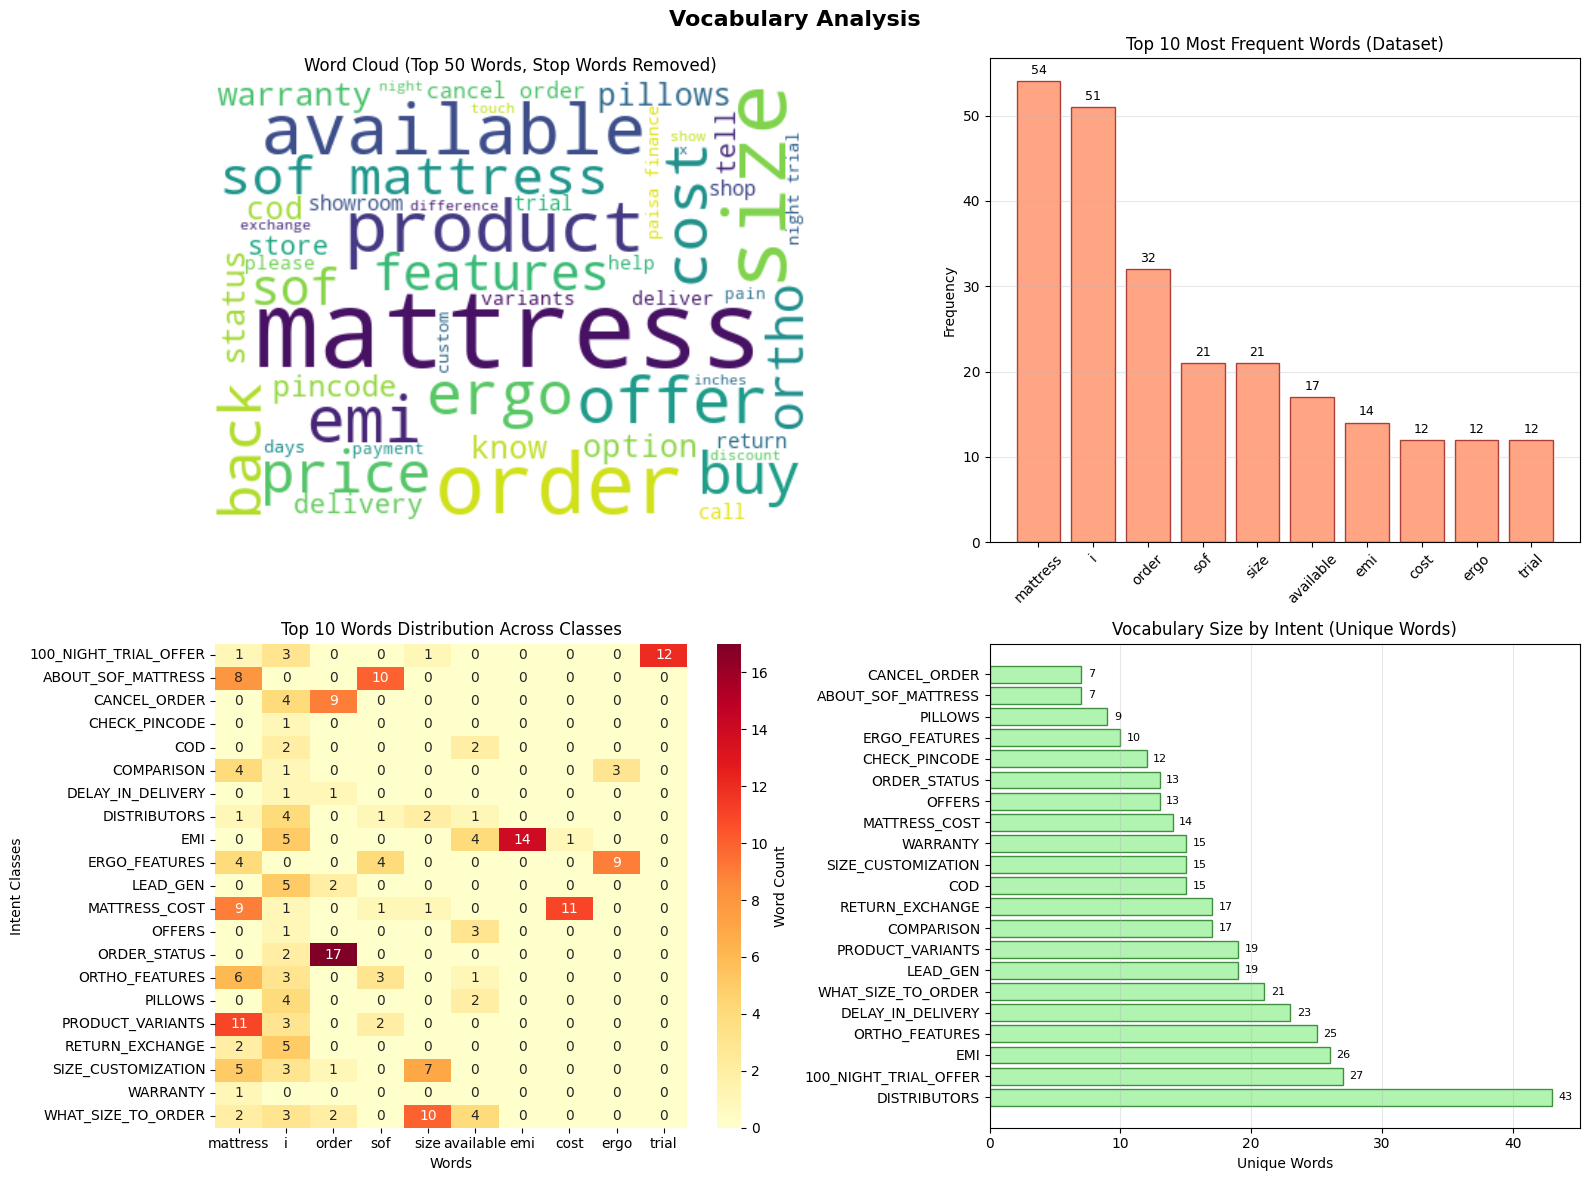


🎯 INTENT-SPECIFIC ANALYSIS
--------------------------------
Intent-wise Statistics:
----------------------------------------------------------------------
Intent                    Samples  Avg_Len  Avg_Words  Vocab   
----------------------------------------------------------------------
DISTRIBUTORS              34       22.1     4.3        69      
EMI                       25       20.6     4.0        48      
MATTRESS_COST             22       14.3     2.9        26      
LEAD_GEN                  21       18.2     4.1        35      
PRODUCT_VARIANTS          21       22.2     3.9        34      
ORDER_STATUS              21       18.7     3.9        32      
WHAT_SIZE_TO_ORDER        20       20.9     4.2        39      
100_NIGHT_TRIAL_OFFER     18       24.3     4.8        44      
ORTHO_FEATURES            17       24.1     4.4        41      
RETURN_EXCHANGE           14       20.0     3.9        29      
COD                       12       22.0     4.6        27      
COMPA

In [11]:

df, word_freq, class_word_freq = run_complete_eda('/Users/santhosh/Documents/Tifin_Test_1/data/sofmattress_train.csv')

In [17]:
class_word_freq

{'100_NIGHT_TRIAL_OFFER': Counter({'trial': 12,
          '100': 11,
          'night': 7,
          'offer': 3,
          'i': 3,
          'days': 2,
          'free': 2,
          'nights': 2,
          'work': 1,
          'details': 1,
          'enroll': 1,
          'return': 1,
          'applicable': 1,
          'custom': 1,
          'size': 1,
          'well': 1,
          'customisation': 1,
          'provide': 1,
          'exchange': 1,
          'try': 1,
          'mattress': 1,
          'first': 1,
          'check': 1,
          'offers': 1,
          'get': 1,
          'version': 1,
          'give': 1}),
 'ABOUT_SOF_MATTRESS': Counter({'sof': 10,
          'mattress': 8,
          'tell': 3,
          'different': 2,
          'brands': 1,
          'mattresses': 1,
          'company': 1}),
 'CANCEL_ORDER': Counter({'order': 9,
          'cancel': 8,
          'i': 4,
          'cancellation': 1,
          'status': 1,
          'process': 1,
          'cancel